# Ptychography Tutorial 03

This is the third tutorial notebook in the iterative ptychography series.  
In this tutorial notebook we will cover:
- Parameter optimization

### Downloads
This tutorial uses the following datasets:
- [ptycho_ducky_simulation_03.h5](https://drive.google.com/file/d/1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI/view?usp=drive_link)
- [ptycho_ducky_vacuum-probe_03.h5](https://drive.google.com/file/d/1aiZbsXU1dUf4RIHZDLUbWsGZlZZAaClM/view?usp=drive_link)

### Acknowledgements

This tutorial was created by the py4DSTEM `phase_contrast` team:
- Steven Zeltmann (steven.zeltmann@lbl.gov)
- Georgios Varnavides (gvarnavides@berkeley.edu)
- Stephanie Ribet (sribet@lbl.gov)
- Colin Ophus (clophus@lbl.gov)

Last updated 2024 May 3

## Parameter Optimization
We have already seen the importance of having accurate calibrations for phase retrieval, and investigated two powerful methods for obtaining good estimates:
- DPC: CoM curl minimization &rarr; rotation estimate
- Parallax: Cross-correlation shifts fitting &rarr; rotation, defocus, astigmatism etc estimates

There are however additional parameters, such as the reciprocal-space pixel-size, sample thickness (multi-slice) etc, which these methods don't inform us about and are of crucial importance to ptychographic reconstructions.

Here, we present a general framework to perform grid-search as-well as Bayesian inference optimization using Gaussian processes.

### Ducky Simulated Data
We'll investigate the optimizer using the simulated ducky dataset we've been looking at, where we know the true calibrations

In [1]:
%pip install py4DSTEM

In [2]:
import numpy as np
import py4DSTEM
import matplotlib.pyplot as plt

print(py4DSTEM.__version__)

%matplotlib inline
#plt.close('all')

0.14.16


In [3]:
# Get the 4DSTEM data
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI',
    destination = '/content/',
    filename = 'ptycho_ducky_simulation_03.h5',
    overwrite=True
)

# Get the probe
py4DSTEM.io.gdrive_download(
    id_ = 'https://drive.google.com/uc?id=1aiZbsXU1dUf4RIHZDLUbWsGZlZZAaClM',
    destination = '/content/',
    filename = 'ptycho_ducky_vacuum-probe_03.h5',
    overwrite=True
)

Downloading...
From (original): https://drive.google.com/uc?id=1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI
From (redirected): https://drive.google.com/uc?id=1rCWIokqDGINpex_zYz4ryiiEkfuh1xTI&confirm=t&uuid=32522874-0af5-45ed-b53f-192e7a8a6177
To: /content/ptycho_ducky_simulation_03.h5
100%|██████████| 538M/538M [00:05<00:00, 97.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1aiZbsXU1dUf4RIHZDLUbWsGZlZZAaClM
To: /content/ptycho_ducky_vacuum-probe_03.h5
100%|██████████| 336k/336k [00:00<00:00, 94.8MB/s]


In [4]:
file_path = '/content/'
file_data = file_path + 'ptycho_ducky_simulation_03.h5'
file_probe = file_path + 'ptycho_ducky_vacuum-probe_03.h5'

dataset = py4DSTEM.read(file_data)
probe = py4DSTEM.read(file_probe)
dataset.calibration

Calibration( A Metadata instance called 'calibration', containing the following fields:

             Q_pixel_size:     0.025
             R_pixel_size:     4.0
             Q_pixel_units:    A^-1
             R_pixel_units:    A
             QR_flip:          False
             _root_treepath:   
)

First, let's reproduce the reconstruction from the previous tutorial using the true calibration values.

Reconstructing object and probe: 100%|██████████| 64/64 [00:29<00:00,  2.20 iter/s]


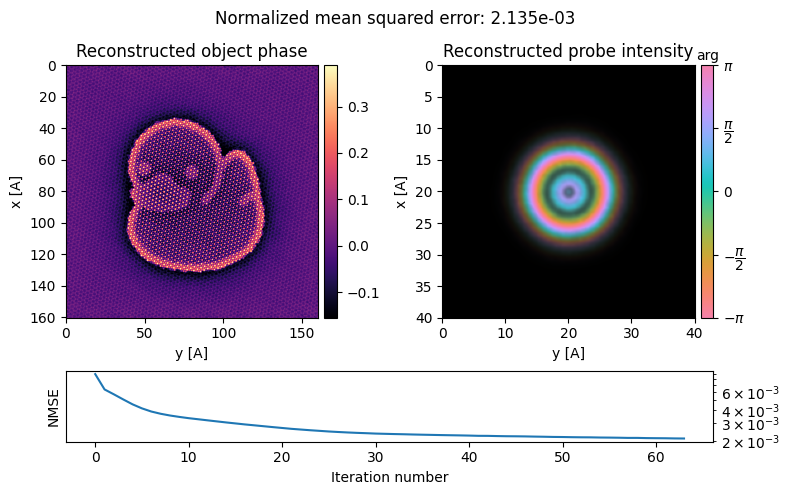

In [5]:
ptycho = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dataset,
    energy=80e3,
    defocus=500,
    vacuum_probe_intensity=probe.data,
    verbose=False,
    device='gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    num_iter = 64,
    seed_random=0,
    max_batch_size=512,
).visualize(
)

And investigate how the reconstruction quality degrades if one of rotation, defocus, reciprocal-space calibration is off by 15%

Reconstructing object and probe: 100%|██████████| 64/64 [00:30<00:00,  2.09 iter/s]


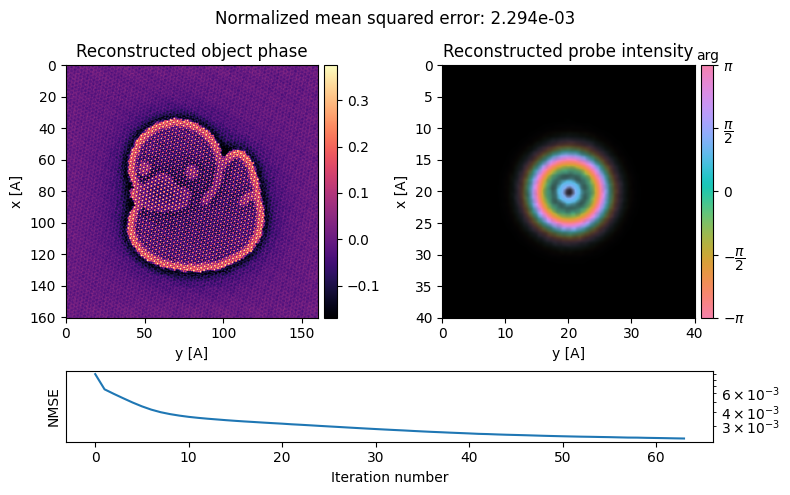

In [6]:
ptycho_wrong_defocus = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dataset,
    energy=80e3,
    defocus=0.85 * 500,
    vacuum_probe_intensity=probe.data,
    verbose=False,
    device='gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    num_iter = 64,
    seed_random=0,
    max_batch_size=512,
).visualize(
)

Reconstructing object and probe: 100%|██████████| 64/64 [00:23<00:00,  2.76 iter/s]


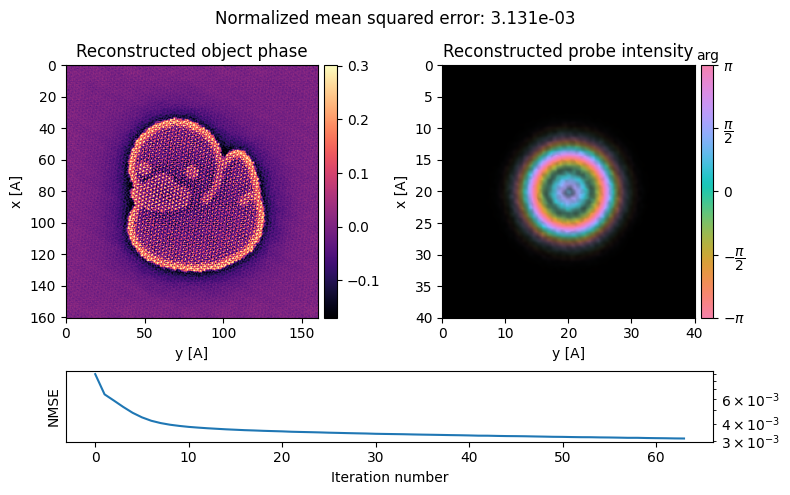

In [7]:
ptycho_wrong_rotation = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dataset,
    energy=80e3,
    defocus=500,
    vacuum_probe_intensity=probe.data,
    verbose=False,
    device='gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    plot_center_of_mass = False,
    force_com_rotation = -15*0.85,
    plot_probe_overlaps=False,
).reconstruct(
    num_iter = 64,
    seed_random=0,
    max_batch_size=512,
).visualize(
)

Reconstructing object and probe: 100%|██████████| 64/64 [00:22<00:00,  2.82 iter/s]


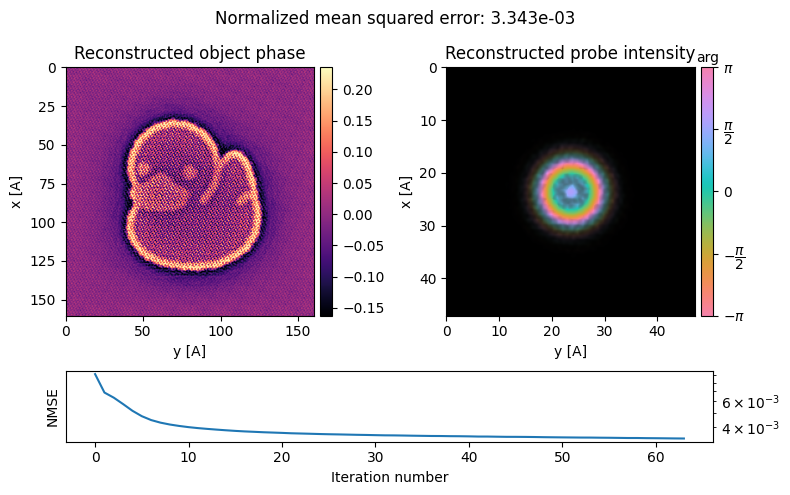

In [8]:
ptycho_wrong_pixelsize = py4DSTEM.process.phase.SingleslicePtychography(
    datacube=dataset,
    energy=80e3,
    defocus=500,
    vacuum_probe_intensity=probe.data,
    verbose=False,
    device='gpu', # uncomment if you have access to a GPU
    storage='cpu', # uncomment if you have access to a GPU
).preprocess(
    force_reciprocal_sampling=0.025*0.85,
    plot_center_of_mass = False,
    plot_rotation=False,
    plot_probe_overlaps=False,
).reconstruct(
    num_iter = 64,
    seed_random=0,
    max_batch_size=512,
).visualize(
)

It's interesting to note how more sensitive some calibrations are over others, and how different the failure modes are!

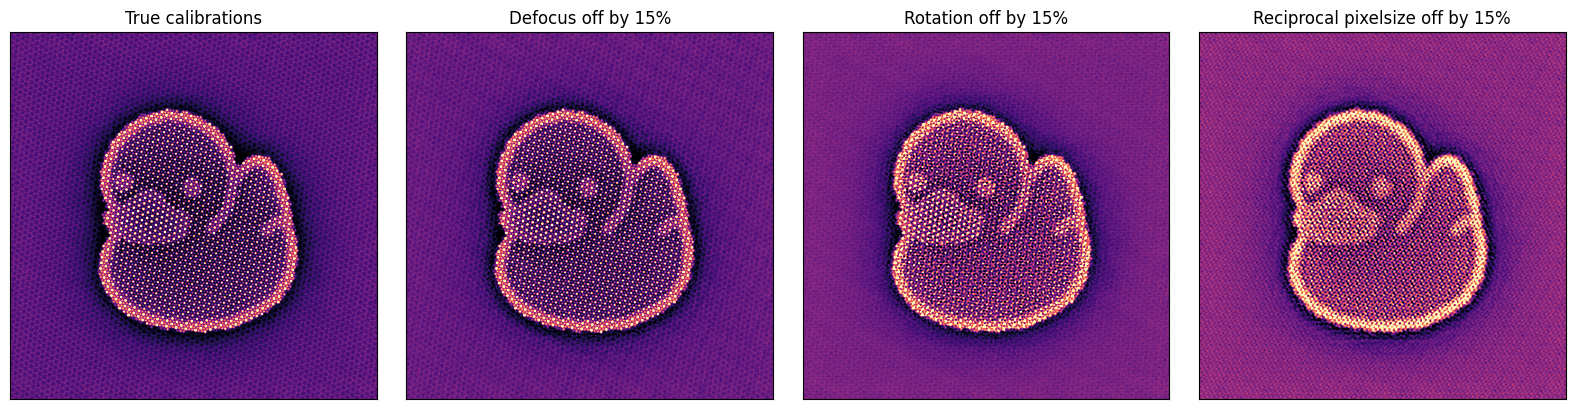

In [9]:
py4DSTEM.show(
    [
        np.angle(ptycho.object_cropped),
        np.angle(ptycho_wrong_defocus.object_cropped),
        np.angle(ptycho_wrong_rotation.object_cropped),
        np.angle(ptycho_wrong_pixelsize.object_cropped),
    ],
    cmap='magma',
    ticks=False,
    title=["True calibrations","Defocus off by 15%","Rotation off by 15%","Reciprocal pixelsize off by 15%"],
    axsize=(4,4),
)

### Ptychography Optimizer & Optimization Parameter

As we've seen all ptychographic functions in py4DSTEM follow the framework:
```python
XxPtychography(
    **init_args
).preprocess
    **preprocess_args
).reconstruct(
    **reconstruction_args
)
```

The optimizer is thus built around this framework and accepts the ptychographic class as its first argument, followed by the init, preprocess, and reconstruction argument dictionaries
```python
PtychographyOptimizer(
    XxPtychography,
    init_args = init_args,
    preprocess_args = preprocess_args,
    reconstruction_args = reconstruction_args,
)
```

In each dictionary, parameters to be optimized are passed wrapped in an `OptimizationParameter` object, specified as
```python
OptimizationParameter(
    initial_value,
    lower_bound,
    upper_bound,
)
```
`OptimizationParameter` assumes parameters are real numbers by default, but also supports boolean and integer arguments using the `space` keyword argument.

Let's translate the ducky parameters to these dictionaries. We'll start with the reciprocal pixel-size, since it's so sensitive.

In [10]:
from py4DSTEM.process.phase.parameter_optimize import OptimizationParameter, PtychographyOptimizer

init_args = {
    'datacube':dataset,
    'energy':80e3,
    'vacuum_probe_intensity':probe.data,
    'device':'gpu',
    'storage':'cpu',
    'defocus':500,
}

preprocess_args = {
    'force_reciprocal_sampling':OptimizationParameter(0.025,0.01,0.04),
    'force_com_rotation': -15,
    'force_com_transpose': False,
}

recon_args = {
    'num_iter':8,
    'max_batch_size':512,
}

optimizer = PtychographyOptimizer(
    py4DSTEM.process.phase.SingleslicePtychography,
    init_args = init_args,
    preprocess_args = preprocess_args,
    reconstruction_args = recon_args,
)

### Grid-search
The simplest optimization is to perform a grid-search. This ignores the `initial_value` argument of `OptimizationParameter` and instead evaluates the ptychography model using equally-distributed `n_points` between the `lower_bound` and `upper_bound`.

Searching parameters: 100%|██████████| 5/5 [00:23<00:00,  4.67s/it]


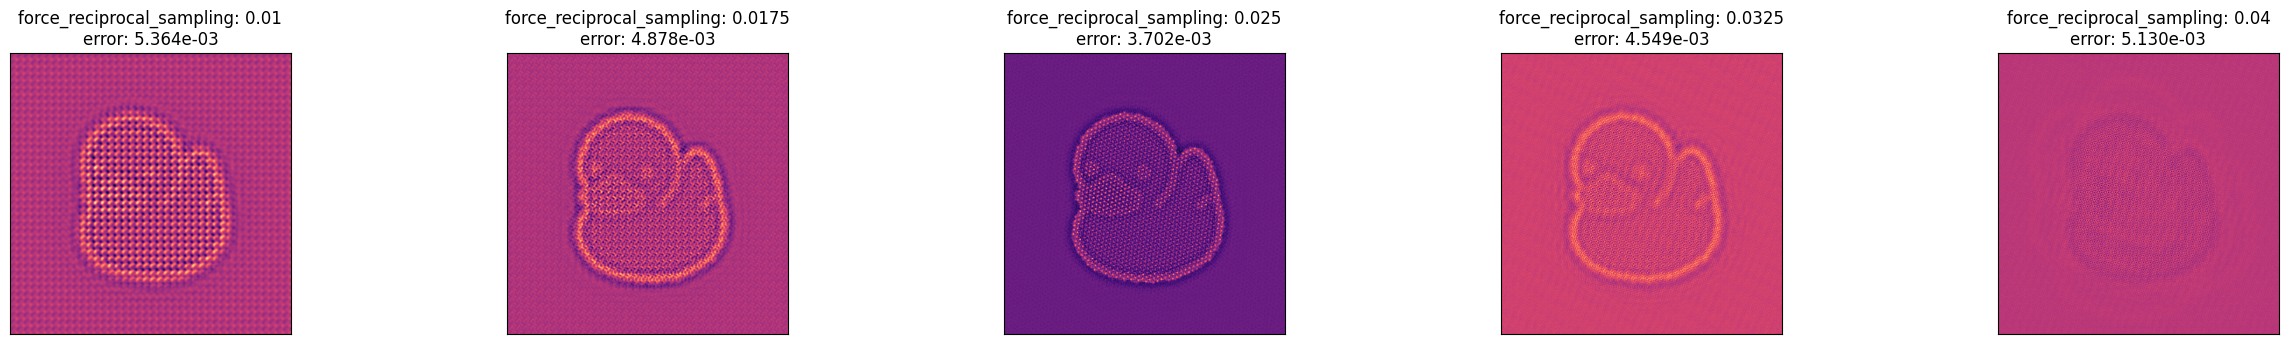

In [11]:
optimizer.grid_search(
    n_points=(5,),
    error_metric="linear",
    plot_reconstructed_objects=True,
    return_reconstructed_objects=False,
    figsize=(25,6.5),
    ncols = 5,
)

We can see the true calibrations demonstrate a global minimum (although note we used a rather aggressive range).

### Bayesian-Optimization with Gaussian Processes

Alternatively, we can perform a more efficient search using Bayesian optimization with Gaussian processes (as implemented in [scikit-optimize](https://scikit-optimize.github.io/stable/)).

Optimizing parameters: 100%|██████████| 50/50 [03:49<00:00,  4.60s/it]


Optimized parameters:
force_reciprocal_sampling: 0.02434872389476688


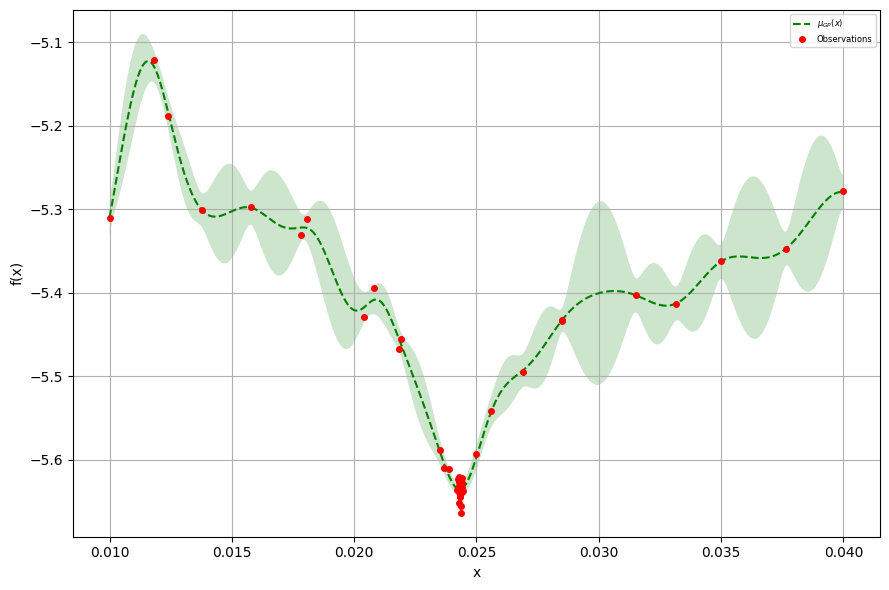

In [12]:
optimizer.optimize(
    n_calls=50,
    n_initial_points=15,
    error_metric='log',
)
optimizer = optimizer.visualize()

We can also optimize more than one parameters at a time (although note this is not always advisable).  
Here, we optimize defocus and rotation jointly and plot the partial dependence of each parameter on the error metric.

Optimizing parameters: 100%|██████████| 50/50 [03:55<00:00,  4.71s/it]


Optimized parameters:
defocus: 472.56476663425747
force_com_rotation: -15.174560626947269


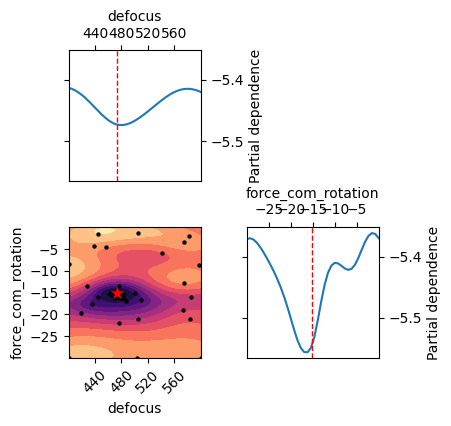

In [13]:
# Replace/add Optimization parameters in the argument dictionaries
preprocess_args.pop('force_reciprocal_sampling',None)
init_args['defocus']=OptimizationParameter(500,400,600)
preprocess_args['force_com_rotation']=OptimizationParameter(-15,-30,0)

optimizer_defocus_rotation = PtychographyOptimizer(
    py4DSTEM.process.phase.SingleslicePtychography,
    init_args = init_args,
    preprocess_args = preprocess_args,
    reconstruction_args = recon_args,
)

optimizer_defocus_rotation.optimize(
    n_calls=50,
    n_initial_points=15,
    error_metric='log',
)
optimizer_defocus_rotation = optimizer_defocus_rotation.visualize()

Notice how the optimized result is not in-fact the true calibration of 500 A defocus!  
This highlights the risks of blindly using the self-consistency error as an optimization function. To remedy this, `optimize` function accepts an `error_metric` argument, with a variety of predefined and custom metrics.